In [2]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [3]:
dir=r'D:\dataset\butterfly\train'

In [4]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=8,
image_size=(224, 224),
shuffle=True,
seed=10,
validation_split=0.1,
subset='training',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)


validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=8,
image_size=(224, 224),
shuffle=True,
seed=10,
validation_split=0.1,
subset='validation',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Found 1257 files belonging to 10 classes.
Using 1132 files for training.
Found 1257 files belonging to 10 classes.
Using 125 files for validation.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

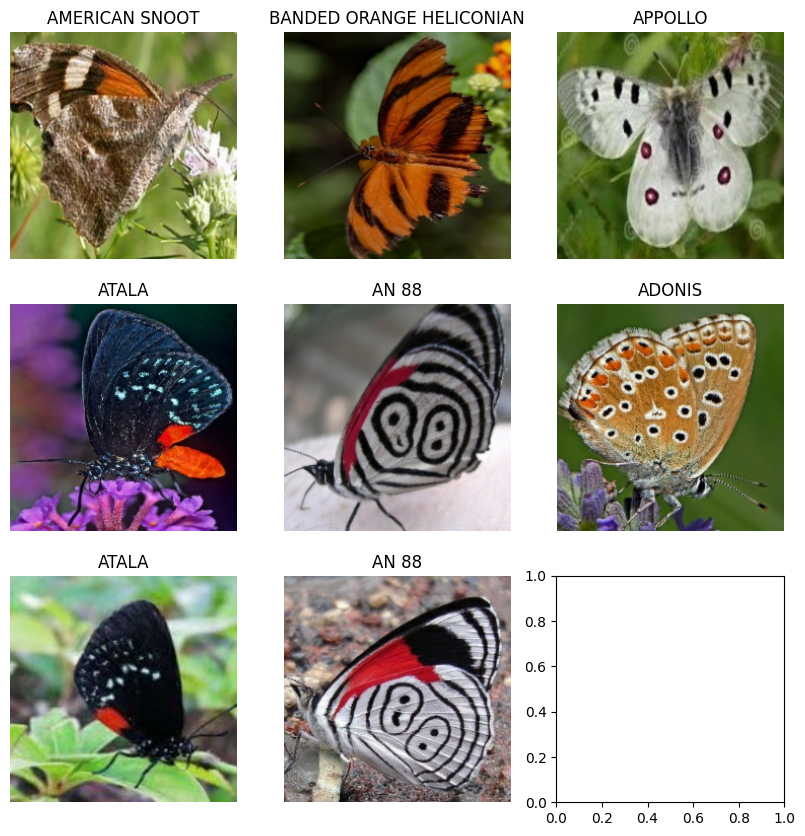

In [10]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [7]:
def Convblock(x,k):
    x1=layers.BatchNormalization()(x)
    x1=layers.ReLU()(x1)
    x1=layers.Conv2D(filters=4*k,kernel_size=(1,1),strides=(1,1),padding='same')(x1)
    
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)
    x1=layers.Conv2D(filters=k,kernel_size=(3,3),strides=(1,1),padding='same')(x1)
    
    x2=tf.keras.layers.Concatenate()([x,x1])

    return x2

def DenseBlock_1(x,k):
    for i in range(6):
        x_temp=Convblock(x,k)
        x=x_temp
    return x

def DenseBlock_2(x,k):
    for i in range(12):
        x_temp=Convblock(x,k)
        x=x_temp
    return x

def DenseBlock_3(x,k):
    for i in range(48):
        x_temp=Convblock(x,k)
        x=x_temp
    return x

def DenseBlock_4(x,k):
    for i in range(32):
        x_temp=Convblock(x,k)
        x=x_temp
    return x

def Transition_layer(x,k,theta):
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Conv2D(filters=(256+3*k)*theta,kernel_size=(1,1),use_bias=False,strides=(1,1),padding='same',)(x)
    x=layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
    return x

def Classification_layer(x):
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dense(units=10,activation='softmax')(x)
    return x

In [8]:
input=Input(shape=(224,224,3))
x=layers.BatchNormalization()(input)
x=layers.ReLU()(x)
x=layers.Conv2D(filters=256,kernel_size=(7,7),strides=(2,2),padding='same')(x)
x=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

x=DenseBlock_1(x,32)
x=Transition_layer(x,32,0.5)

x=DenseBlock_2(x,32)
x=Transition_layer(x,32,0.5)

x=DenseBlock_3(x,32)
x=Transition_layer(x,32,0.5)

x=DenseBlock_4(x,32)

output=Classification_layer(x)

model = tf.keras.models.Model(input,output)

In [4]:
len(model.layers)
#ReLU레이어 제외시 507개 레이어

705

In [ ]:
model.summary()

In [ ]:
plot_model(model,to_file='DenseNet.png',show_shapes=True)

In [ ]:
import tensorflow as tf
import numpy as np

with tf.device("/device:CPU:0"): 
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

# Normalization
x_train=x_train/255.

x_test=x_test/255.

x_train.shape

x_train = tf.image.resize(x_train, [224,224]) 

x_test = tf.image.resize(x_test, [224,224]) 

y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [9]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy' ,metrics=['acc'])

In [ ]:
with tf.device("/device:GPU:0"):
    history=model.fit(train_ds,validation_data=validation_ds,epochs=100,batch_size=16,verbose=1)